## City of Seattle - Crime Location Heat Map

This notebook reads a file of crime data available at the city of Seattle's public data web site, and then creates a Seaborn heat map.  The heat map divides the city into a grid and uses color intensity to show the number of crimes committed in each section of the grid.

In [1]:
import pandas as pd
import seaborn as sns

The data is from the "SPD Crime Data: 2008-present" CSV file located at the City of Seattle Open Data Portal (https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5).  The data is refreshed daily.  As of May 2021 the file contains slightly over 900K rows and may take a while to load.

In [2]:
url = "https://data.seattle.gov/api/views/tazs-3rd5/rows.csv"

df = pd.read_csv(url)

Let's list all of the columns in the dataframe.

In [3]:
for name in df.columns:
    print(name)

Report Number
Offense ID
Offense Start DateTime
Offense End DateTime
Report DateTime
Group A B
Crime Against Category
Offense Parent Group
Offense
Offense Code
Precinct
Sector
Beat
MCPP
100 Block Address
Longitude
Latitude


There are some anomalies with the data.  Currently there are about 36000 rows that don't contain latitude/longitude values.  There are also a few wrong "Offense Start DateTime" year values, such as 1908 and 1915 (and about 900 null values).  We'll filter out these rows later.

First, let's round the latitude/longitude values.  These have a precision of six decimal places, which would make the heat map look like a pattern of dots with considerable white space.  (The column definitions, found at the above link, state that the coordinates are "blurred to the one hundred block".  Likely for privacy reasons, this ensures that the actual crime locations cannot be determined precisely.)

For this notebook I've chosen to round to three decimal places and create new columns to store the rounded values.

In [4]:
precision = 3
df['Lat'] = df['Latitude'].round(precision)
df['Lon'] = df['Longitude'].round(precision)

The "Offense" column classifies the type of crime committed.  The following statement prints all the possible values:

In [5]:
print(df['Offense'].value_counts(dropna=False).sort_index())

Aggravated Assault                              30290
All Other Larceny                               79437
Animal Cruelty                                     75
Arson                                            1600
Assisting or Promoting Prostitution               275
Bad Checks                                       6631
Betting/Wagering                                   21
Bribery                                            16
Burglary/Breaking & Entering                   104790
Counterfeiting/Forgery                           4976
Credit Card/Automated Teller Machine Fraud      18316
Curfew/Loitering/Vagrancy Violations              893
Destruction/Damage/Vandalism of Property        86473
Driving Under the Influence                     16713
Drug Equipment Violations                        3897
Drug/Narcotic Violations                        22970
Drunkenness                                         9
Embezzlement                                     1923
Extortion/Blackmail         

For purposes of this program, I assume the "Offense Start Date" represents the date that the crime occurred.

Because Pandas created the date columns as strings, I will create a new column that converts the "Offense Start Date" string to a Pandas date value.  (This step takes a while because of the size of the dataframe.)

In [6]:
df["StartDate"] = pd.to_datetime(df["Offense Start DateTime"])

Let's take a subset of the dataframe.  We'll report on motor vehicle thefts, and we'll filter out invalid dates by selecting data from 2011 to 2020.  We'll also filter out those rows with zero latitude values.

In [7]:
df_theft = df[(df.Offense.str.contains('Theft From Motor Vehicle', na=False))
              & (df.Lat != 0)
              & (df.StartDate > "2010-12-31")
              & (df.StartDate < "2021-01-01")]

Here we'll summarize the occurences by latitude and longitude and create another dataframe.  So that the resulting heat map is oriented correctly, we negate the latitude value (otherwise the heat map would appear upside-down).

In [8]:
df_all = pd.DataFrame(data=df_theft.groupby(['Lat', 'Lon']).size(),
                      columns=['all_value'])
df_all.reset_index(inplace=True)

df_all['Lat'] = df_all['Lat'] * -1

Now we'll create a pivot table  This will be used as input to the Seaborn heat map routine.

In [9]:
result = df_all.pivot(index='Lat', columns='Lon', values='all_value')

By default, higher values on a heat map square will result in a lighter shade.  Let's flip that so that the shade will be darker for higher values.  Let's also set the dimensions of the heat map.  (I had to experiment with the dimensions to get a heat map that closely resembles an actual map of Seattle.)

In [10]:
cmap = sns.cm.rocket_r
sns.set(rc={'figure.figsize': (8, 14)})

Finally let's create the heatmap and save it if desired.  The vmin and vmax values represent the mininum and maximum values of the result.  (I chose the vmax value by examining the dataframe, this should be done automatically.)

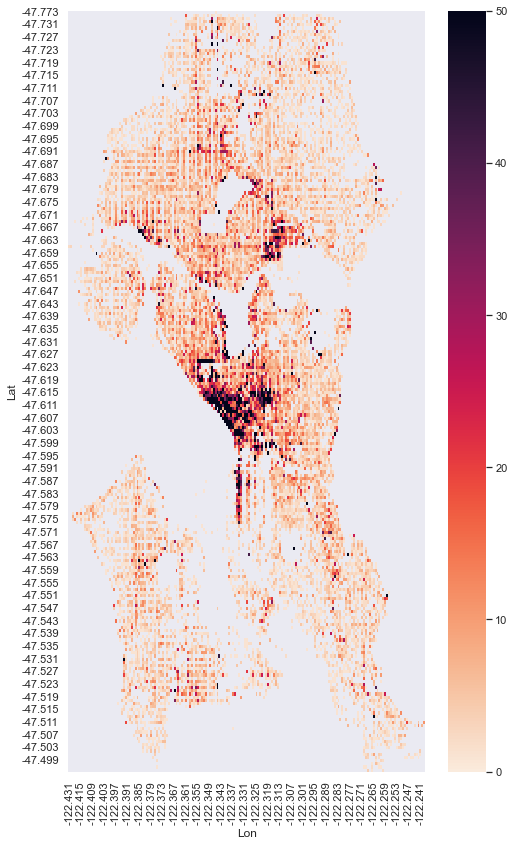

In [11]:
hm = sns.heatmap(result, vmin=0.0, vmax=50.0, cmap=cmap)
fig = hm.get_figure()
fig.savefig("SeattleTheftFromMotorVehicle.png")